# MBTA Bus Arrival Departure
### Setup
Ensure the packages are installed listed below and ensure departure_arrival folder is created on the same directory as final.ipynb with the csv files taken from "MBTA Bus Arrival Departure Times 20__".

[MBTA Bus Arrival Departure Times 2024](https://mbta-massdot.opendata.arcgis.com/datasets/mbta-bus-arrival-departure-times-2024)

[MBTA Bus Arrival Departure Times 2023](https://mbta-massdot.opendata.arcgis.com/datasets/mbta-bus-arrival-departure-times-2023)

[MBTA Bus Arrival Departure Times 2022](https://mbta-massdot.opendata.arcgis.com/datasets/ef464a75666349f481353f16514c06d0/about)

[MBTA Bus Arrival Departure Times 2021](https://mbta-massdot.opendata.arcgis.com/datasets/2d415555f63b431597721151a7e07a3e/about)

[MBTA Bus Arrival Departure Times 2020](https://mbta-massdot.opendata.arcgis.com/datasets/4c1293151c6c4a069d49e6b85ee68ea4/about)

[MBTA Bus Arrival Departure Times 2019](https://mbta-massdot.opendata.arcgis.com/datasets/1bd340b39942438685d8dcdfe3f26d1a/about)

[MBTA Bus Arrival Departure Times 2018](https://mbta-massdot.opendata.arcgis.com/datasets/d685ba39d9a54d908f49a2a762a9eb47/about)

The results are stored in the results folder if you wish to look through that rather than running the notebook.

Ensure "stops.csv" is downloaded from MBTA website for stop latitude and longitude calculations.

[MBTA GTFS](https://www.mbta.com/developers/gtfs)

Rename stops.txt to stops.csv directly

#### Testing
In regards to testing, run ./test.sh to install dependencies and run tests. Tests were performed on a Mac, if run on a Windows machine, the test will fail (due to how it outputs directories ['/' vs '\', etc] and ordering of directories)

In [ ]:
import pandas as pd
import glob
from tqdm import tqdm

file_pattern = "departure_arrival/*.csv"
csv_files = sorted(glob.glob(file_pattern))

stops = pd.read_csv("stops.csv")

print(csv_files)

### Data Parsing & Calculation
Data calculations will take around 10 minutes per year. The following was tested on csv's from 2018-2024. The data format may change (such as column name) that may require modifications of parsing. This already happens in 2019 where the column name and encoding changes so adjust accordingly.

Running the blocks below will result in 2 CSV files "final_stop_summary.csv" and "final_route_summary.csv" that will both contain their respective ID, month, total lateness, sample size, and average lateness. "final_stop_summary" also includes coordinates which we can use for ARCGIS later.

In [ ]:
total_lateness_results = []
count_results = []
stop_lateness_results = []
stop_count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    print(f"Processing {csv_file} in chunks...")

    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size, encoding='utf-8-sig'))):
        chunk.columns = chunk.columns.str.strip().str.replace("\ufeff", "", regex=False).str.lower()

        chunk.columns = [col.lower().replace("servicedate", "service_date") for col in chunk.columns]
        chunk.columns = ["stop_id" if col.lower() == "stop" else col for col in chunk.columns]
        chunk.columns = ["route_id" if col.lower() == "route" else col for col in chunk.columns]


        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk = chunk.dropna(subset=["service_date"])

        chunk["month"] = chunk["service_date"].dt.to_period("M").astype(str)

        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.strftime("%H:%M:%S")
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.strftime("%H:%M:%S")

        chunk["scheduled"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["scheduled"])
        chunk["actual"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["actual"])

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()
        total_lateness_per_route = chunk.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby(["route_id", "month"], as_index=False).size()
        count_results.append(route_counts)

        total_lateness_per_stop = chunk.groupby(["stop_id", "month"], as_index=False)["lateness"].sum()
        stop_lateness_results.append(total_lateness_per_stop)

        stop_counts = chunk.groupby(["stop_id", "month"], as_index=False).size()
        stop_count_results.append(stop_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)

In [ ]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)
final_stop_lateness_chunks = pd.concat(stop_lateness_results, ignore_index=True)
final_stop_counts_chunks = pd.concat(stop_count_results, ignore_index=True)

final_route_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_route_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_route_summary = final_route_total_lateness.merge(final_route_counts, on=["route_id", "month"], how="left")
final_route_summary["average_lateness"] = final_route_summary["lateness"] / final_route_summary["size"]

final_route_summary.to_csv("results/final_route_summary.csv", index=False)

final_stop_total_lateness = final_stop_lateness_chunks.groupby(["stop_id", "month"], as_index=False)["lateness"].sum()
final_stop_counts = final_stop_counts_chunks.groupby(["stop_id", "month"], as_index=False).sum()
final_stop_summary = final_stop_total_lateness.merge(final_stop_counts, on=["stop_id", "month"], how="left")
final_stop_summary["average_lateness"] = final_stop_summary["lateness"] / final_stop_summary["size"]
stops["stop_id"] = stops["stop_id"].astype(str)
final_stop_summary["stop_id"] = final_stop_summary["stop_id"].astype(str)


final_stop_summary_with_coords = final_stop_summary.merge(
    stops[["stop_id", "stop_lat", "stop_lon"]], 
    on="stop_id", 
    how="left"
)

final_stop_summary_with_coords.to_csv("results/final_stop_summary.csv", index=False)

## Answering Questions
The blocks below aim to answer questions asked by the Spark! project.

- On average, how long does an individual have to wait for a bus (on time vs. delayed)?
- What is the average delay time of all routes across the entire city?
- What is the average delay time of the target bus routes (22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14 - from Livable Streets report)?
- Can we chart changes over TIME?
- Are there disparities in the service levels of different routes (which lines are late more often than others)?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#### On average, how long does an individual have to wait for a bus (on time vs. delayed)? & What is the average delay time of all routes across the entire city? & What is the average delay time of the target bus routes (22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14 - from Livable Streets report)?
The first question asks for the average delay time of all stops and the second question asks for the average delay time for all routes. The third question just requires us to look at average delay time for each of these routes. These blocks assume that you either have the final route and summary calculated or downloaded. If the target bus routes are different, modify it in the cell below.

In [ ]:
final_route_summary = pd.read_csv("results/final_route_summary.csv")
final_stop_summary = pd.read_csv("results/final_stop_summary.csv")

In [ ]:
target_routes = [22, 29, 15, 45, 28, 44, 42, 17, 23, 31, 26, 111, 24, 33, 14]

target_routes = [str(r) for r in target_routes]
final_stop_summary["year"] = final_stop_summary["month"].str[:4].astype(int)
final_route_summary["year"] = final_route_summary["month"].str[:4].astype(int)

# Q1: Stop average lateness by year
print("Q1: Stop average lateness by year")
stop_lateness_by_year = (
    final_stop_summary
    .groupby("year")[["lateness", "size"]]
    .apply(lambda df: df["lateness"].sum() / df["size"].sum())
)
for year, avg in stop_lateness_by_year.items():
    print(f"{year}: {avg:.2f}")

# Q2: Route average lateness by year
print("\nQ2: Route average lateness by year")
route_lateness_by_year = (
    final_route_summary
    .groupby("year")[["lateness", "size"]]
    .apply(lambda df: df["lateness"].sum() / df["size"].sum())
)
for year, avg in route_lateness_by_year.items():
    print(f"{year}: {avg:.2f}")

# Q3: Target route average lateness by year
print("\nQ3: Target route average lateness by year")
target_route_lateness_by_year = {}
for route in target_routes:
    route_data = final_route_summary[final_route_summary["route_id"] == route]
    if not route_data.empty:
        yearly_avg = (
            route_data
            .groupby("year")[["average_lateness", "size"]]
            .apply(lambda df: (df["average_lateness"] * df["size"]).sum() / df["size"].sum())
        )
        target_route_lateness_by_year[route] = yearly_avg

        for year, avg in yearly_avg.items():
            print(f"Route {route} ({year}): {avg:.2f}")
    else:
        print(f"Route {route}: No data found")

#### Can we chart changes over TIME?
The blocks below assume you've ran the previous 2 cells.

Although we answered the previous questions, let's plot them on a graph to see any noticable trends.

Stop summary can be seen visually through ArcGIS Online. There are some things to note. Due to the fact that (most likely) the stops.csv doesn't keep track of disbanded stops, certain stops from previous years have no match on the stops.csv. If you wish to graph on ArcGIS, you will need to remove values that have no matches. Use the resulting "arcgis_final_stop_summary.csv" when importing files into arcgis

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(stop_lateness_by_year.index, stop_lateness_by_year.values, label="Stop Average Lateness")
plt.plot(route_lateness_by_year.index, route_lateness_by_year.values, label="Route Average Lateness")
plt.xlabel("Year")
plt.ylabel("Average Lateness (seconds)")
plt.title("Stop vs Route Average Lateness by Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
for route, series in target_route_lateness_by_year.items():
    plt.plot(series.index, series.values, label=f"Route {route}")

plt.xlabel("Year")
plt.ylabel("Weighted Avg Lateness (seconds)")
plt.title("Target Route Lateness by Year")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
final_stop_summary = pd.read_csv("final_stop_summary.csv")
final_stop_summary.isna().sum()
arcgis_final_stop_summary = final_stop_summary.dropna()

arcgis_final_stop_summary.to_csv("results/arcgis_final_stop_summary.csv", index=False)

### Modeling

The modeling section assumes that you've run the data collection section of the notebook. We use KNN and DBScan and require location positions, so we'll only be runnning on the final_stop_summary.csv. This suffers from the same issue as working with ArcGIS; Certain stops don't have values presumabley because they don't exist anymore. We drop these for code to run.

In [ ]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import shutil
import os
from matplotlib.colors import ListedColormap
import glob
from PIL import Image as PILImage
from IPython.display import Image as IPyImage, display
from datetime import datetime

file_path = "results/final_stop_summary.csv"
df = pd.read_csv(file_path)

#### KMeans

In [ ]:
df["year"] = df["month"].str[:4].astype(int)

stop_total_lateness = defaultdict(int)
stop_total_size = defaultdict(int)
stop_lat = {}
stop_long = {}
# Grouping by stop and year to grab mean lateness for a stop given a year
for _, row in df.iterrows():
    key = (row['stop_id'], row['year']) 
    stop_total_lateness[key] += row['lateness']
    stop_total_size[key] += row['size']
    if row['stop_id'] not in stop_lat:
        stop_lat[row['stop_id']] = row['stop_lat']
        stop_long[row['stop_id']] = row['stop_lon']

stop_agg_df = pd.DataFrame({
    "stop_id": [k[0] for k in stop_total_lateness.keys()],
    "year": [k[1] for k in stop_total_lateness.keys()],
    "average_lateness": [
        stop_total_lateness[k] / stop_total_size[k] for k in stop_total_lateness.keys()
    ],
    "stop_lat": [stop_lat[k[0]] for k in stop_total_lateness.keys()],
    "stop_lon": [stop_long[k[0]] for k in stop_total_lateness.keys()]
})

stop_agg_df = stop_agg_df.sort_values(by=["stop_id", "year"]).reset_index(drop=True)
stop_agg_df = stop_agg_df.dropna(subset=["stop_lat", "stop_lon"])

# Scaling to ensure lat & lon is considered
X_original = stop_agg_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)


Here we see which K values yield best results. Which just like running it with one year from the midterm report, is still 7.

In [ ]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [ ]:
os.makedirs("kmeans_frames", exist_ok=True)

cmap = ListedColormap(["lightgray", "orangered"])

years = sorted(stop_agg_df["year"].unique())

for year in years:
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 7:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_k = 7
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    cluster_avg = yearly_df.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()
    avg_lateness = cluster_avg[worst_cluster]
    print(f"Year {year} — Worst Cluster ID: {worst_cluster}, Average Lateness: {avg_lateness:.2f} seconds")


    color_labels = (yearly_df["cluster"] == worst_cluster).astype(int)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        yearly_df["stop_lon"],
        yearly_df["stop_lat"],
        c=color_labels,
        cmap=cmap,
        edgecolor="k",
        linewidth=0.3,
        alpha=0.9
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Stops in Worst Lateness Cluster — {year}")
    plt.grid(True)
    plt.tight_layout()

    frame_path = f"kmeans_frames/clustering_{year}.png"
    plt.savefig(frame_path)
    plt.close()


frame_paths = sorted(glob.glob("kmeans_frames/clustering_*.png"))

frames = [PILImage.open(fp) for fp in frame_paths]

if frames:
    frames[0].save(
        "kmeans_max_lateness_clusters.gif",
        save_all=True,
        append_images=frames[1:],
        duration=1500,
        loop=0
    )
    print("GIF created with PIL: kmeans_max_lateness_clusters.gif")

shutil.rmtree("kmeans_frames", ignore_errors=True)
print("Cleaned up: kmeans_frames/ folder deleted.")

display(IPyImage(filename="kmeans_max_lateness_clusters.gif"))

In [ ]:
worst_cluster_points = []

for year in years:
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 7:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    cluster_avg = yearly_df.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()

    worst_points = yearly_df[yearly_df["cluster"] == worst_cluster].copy()
    worst_points["year"] = year
    worst_cluster_points.append(worst_points)


combined_df = pd.concat(worst_cluster_points, ignore_index=True)
combined_df["date"] = combined_df["year"].apply(lambda y: datetime.strptime(f"{y}-01-01", "%Y-%m-%d"))
combined_df.to_csv("results/kmeans_worst_cluster_by_year.csv", index=False)
print("Exported: kmeans_worst_cluster_by_year.csv")

combined_df

#### DBScan

In [ ]:
import os
import shutil
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime

os.makedirs("dbscan_frames", exist_ok=True)

worst_cluster_points = []
custom_cmap = ListedColormap(["lightgray", "red"])


for year in sorted(stop_agg_df["year"].unique()):
    yearly_df = stop_agg_df[stop_agg_df["year"] == year].dropna()

    if len(yearly_df) < 5:
        continue

    X = yearly_df[["stop_lat", "stop_lon", "average_lateness"]].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    db = DBSCAN(eps=0.48, min_samples=5)
    clusters = db.fit_predict(X_scaled)
    yearly_df = yearly_df.copy()
    yearly_df["cluster"] = clusters

    valid_clusters = yearly_df[yearly_df["cluster"] != -1]
    if valid_clusters.empty:
        continue

    cluster_avg = valid_clusters.groupby("cluster")["average_lateness"].mean()
    worst_cluster = cluster_avg.idxmax()

    yearly_df["highlight"] = (yearly_df["cluster"] == worst_cluster).astype(int)

    worst_points = yearly_df[yearly_df["highlight"] == 1].copy()
    worst_points["year"] = year
    worst_points["date"] = datetime.strptime(f"{year}-01-01", "%Y-%m-%d")
    worst_cluster_points.append(worst_points)

    plt.figure(figsize=(10, 6))
    plt.scatter(
        yearly_df["stop_lon"],
        yearly_df["stop_lat"],
        c=yearly_df["highlight"],
        cmap=custom_cmap,
        alpha=0.9,
        edgecolor="k",
        linewidth=0.3
    )
    plt.title(f"DBSCAN — Worst Lateness Cluster (Year: {year})")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()

    frame_path = f"dbscan_frames/dbscan_{year}.png"
    plt.savefig(frame_path)
    plt.close()

frame_paths = sorted([f for f in os.listdir("dbscan_frames") if f.endswith(".png")])
frames = [PILImage.open(f"dbscan_frames/{fp}") for fp in frame_paths]

if frames:
    frames[0].save(
        "dbscan_max_lateness_clusters.gif",
        save_all=True,
        append_images=frames[1:],
        duration=1500,  
        loop=0
    )
    print("GIF created: dbscan_max_lateness_clusters.gif")

if worst_cluster_points:
    combined_df = pd.concat(worst_cluster_points, ignore_index=True)
    combined_df.to_csv("results/worst_dbscan_clusters_by_year.csv", index=False)
    print("Exported: worst_dbscan_clusters_by_year.csv")

shutil.rmtree("dbscan_frames", ignore_errors=True)
print("Cleaned up: dbscan_frames/ folder deleted.")

display(IPyImage(filename="dbscan_max_lateness_clusters.gif"))


The results regarding DBScan were too suboptimal (even using previous values) that I didn't end up putting it on ArcGIS.

ArcGIS Results:

Stop Lateness 2018 - 2024 & Outliers

https://bucas.maps.arcgis.com/apps/mapviewer/index.html?webmap=bf72597e2856402d934fe400e54f2869

Click on layers to see which dataset you want to see. Set interval to 11 months on the time slider for worst clusters to see the KMeans outlier clusters, and use 2 month slider for final to see the lateness trend change each month

### Conclusion

The conclusion is stated in the readme (our final report), refer to there for more indepth analysis of data and results of modeling

# Rider Survey Data & Lateness

## Data Set Summary

### Pre-Covid (2015-2017)
For the Pre-Covid ridership data, we scraped the information available on the [2018](https://www.ctps.org/dv/mbtasurvey2018/index.html#navButton) which highlights ridership data from 2015-2017, using the `Notebooks/2015-2017-scraper.py file`. This was done to collect .txt files of the 8 sections of ridership data which were only available as excel imports and not accessible tables. The scraper is included in the notebooks folder but for ease of use we will include the associated .txt files as well as a script below to convert these text files into .xlsx, and the file xlsx_to_export.ipynb to convert the xlsx files into tables, which will be utilized in our analysis.

### Post-Covid
Post-Covid ridership data was pulled from the [2023](https://mbta-massdot.opendata.arcgis.com/datasets/faaf1295847e4673a03b40cef2c53df1_0/explore) ridership survey data site which was available as a downloadable table and not just dynamically loaded excel imports.

## Answering Questions

Our section looks to answer the following questions surrounding disparities among routes that display higher amounts of lateness as well as demographic changes over time among these routes.

Spark! Questions:
- Can we chart changes over TIME?
- Are there disparities in the service levels of different routes (which lines are late more often than others)?

### Section Specific Imports/Libraries

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
import glob
from tqdm import tqdm
import os

### Script Converting scraped data into usable tables.

In [ ]:
INPUT_DIR  = "ridership_data/scraped_survey_data"
OUTPUT_DIR = "ridership_data/2015-2017-tables"
os.makedirs(OUTPUT_DIR, exist_ok=True)

txt_files = sorted(glob.glob(os.path.join(INPUT_DIR, "*.txt")))
print(f"Found {len(txt_files)} .txt files to convert.")

for txt_path in txt_files:
    base = os.path.splitext(os.path.basename(txt_path))[0]
    records = []
    with open(txt_path, "r", encoding="utf-8") as fh:
        for line in fh:
            parts = line.strip().split(":", 1)
            if len(parts) != 2:
                continue
            route, pct = parts
            route = route.replace("Route", "").strip()
            pct   = pct.strip().rstrip("%")
            try:
                pct = float(pct)
            except ValueError:
                pct = None
            records.append({"Route": route, "Percent": pct})

    df = pd.DataFrame(records, columns=["Route", "Percent"])
    out_path = os.path.join(OUTPUT_DIR, f"{base}.xlsx")
    df.to_excel(out_path, index=False)
    print(f"  → {base}.xlsx")

print("All files converted!")

Then we ran the file xlsx_to_export.ipynb to convert the xlsx files into tables by iterating through each row and adding it to the categories consecutively. If a row was missing from that route, we drop the route entirely since there was no way of knowing which category had the missing value.

To make it easier, we have the preprepared pre covid export files, and the code below is to compile them all together into one large dataset

In [9]:
# all the export files in 2015-2017
precovid_folder = "ridership_data/2015-2017-tables"
print("Folder contents:", os.listdir(precovid_folder))
file_pattern = os.path.join(precovid_folder, "*export.xlsx")
file_paths   = sorted(glob.glob(file_pattern))
print("Found Excel files:", file_paths)

df_list = [pd.read_excel(file) for file in file_paths]
df_pre = pd.concat(df_list, ignore_index=True)

df_pre.head()

postcovid = os.path.join("ridership_data", "2023.csv")
df_post = pd.read_csv(postcovid)
df_post = df_post[df_post['service_mode'] == 'Bus']

Folder contents: ['fares_data.xlsx', 'income_data.xlsx', 'route_data_export.xlsx', 'trip_purpose_frequency_export.xlsx', 'income_data_export.xlsx', 'other_demographics_data_export.xlsx', 'alt_mode_data.xlsx', 'auto_availability_data_export.xlsx', 'access_mode_data.xlsx', 'access_mode_data_export.xlsx', 'trip_purpose_frequency.xlsx', 'other_demographics_data.xlsx', 'auto_avability_data.xlsx', 'alt_mode_data_export.xlsx', 'race_and_ethnicity_data.xlsx', 'race_and_ethnicity_data_export.xlsx', 'fares_data_export.xlsx']
Found Excel files: ['ridership_data/2015-2017-tables/access_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/alt_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/auto_availability_data_export.xlsx', 'ridership_data/2015-2017-tables/fares_data_export.xlsx', 'ridership_data/2015-2017-tables/income_data_export.xlsx', 'ridership_data/2015-2017-tables/other_demographics_data_export.xlsx', 'ridership_data/2015-2017-tables/race_and_ethnicity_data_export.xlsx', 'ride

## Preparing Pre- and Post-COVID Survey Data

- We first cleaned the pre-COVID survey data by dropping the Mode column and converting all other columns to numeric values. We then calculated the percentage for each response category within each route, and standardized the category names to match the post-COVID format for easier comparison. Afterward, we reshaped the data into a long format with Route, Category, and Pre-COVID Percentage.

- Next, we prepared the post-COVID 2023 survey data by cleaning the column names, scaling the percentages from decimals to percentages (0.25 → 25%), and creating a full_category label by combining the group and category information.

- Finally, we merged the cleaned Pre-COVID and Post-COVID datasets by their full_category names. We grouped the merged data by survey measure (e.g., Income, Race, Access Mode) to allow side-by-side comparisons between Pre-COVID and Post-COVID rider demographics.

- This setup ensures we can directly measure shifts in bus rider characteristics over time.


In [10]:

df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

# mapping of categories from df_post
df_post.columns = df_post.columns.str.strip().str.lower()
df_post['full_category'] = df_post['measure_group'] + ": " + df_post['category']

category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# rename df_pre columns using this mapping
df_post.rename(columns=lambda x: x.strip(), inplace=True)
df_post.rename(columns={
    'weighted_percent': 'percentage'
}, inplace=True)


df_pre.columns, df_post.columns

df_post = df_post.dropna()
df_pre = df_pre.dropna()

In [12]:
df_post.columns = df_post.columns.str.strip().str.lower()
df_post.rename(columns={'weighted_percent': 'percentage'}, inplace=True)
df_post["percentage"] = df_post["percentage"] * 100


df_post['full_category'] = df_post['measure'] + ": " + df_post['category']

# extract unique category names from df_post for renaming df_pre
category_mapping = df_post[['category', 'full_category']].drop_duplicates().set_index('category').to_dict()['full_category']

# drop non-numeric columns from df_pre and convert all to numeric
df_pre_numeric = df_pre.drop(columns=["Mode"], errors="ignore").apply(pd.to_numeric, errors="coerce")

category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()
pre_percentages = df_pre_numeric.apply(lambda x: (x / category_totals[x.name.split(":")[0]]) * 100 if x.name.split(":")[0] in category_totals else x, axis=0)
pre_percentages = pre_percentages.rename(columns=category_mapping)

# convert to DataFrame for merging
pre_percentages = pre_percentages.T
pre_percentages = pre_percentages.reset_index()
pre_percentages = pre_percentages.rename(columns={pre_percentages.columns[0]: 'pre_covid_percent'})
pre_percentages['full_category'] = pre_percentages.index
pre_percentages = pre_percentages.reset_index(drop=True)

# ensure both merge columns are strings
pre_percentages["full_category"] = pre_percentages["full_category"].astype(str)
df_post["full_category"] = df_post["full_category"].astype(str)

# merge with df_post based on full_category
df_comparison = pd.merge(
    pre_percentages,
    df_post[['measure_group', 'full_category', 'percentage']],
    on="full_category",
    how="inner"
)

# create separate tables for each measure_group
grouped_tables = {measure: data for measure, data in df_comparison.groupby("measure_group")}

# display
for measure, table in grouped_tables.items():
    print(f"\nComparison Table for {measure}:")
    display(table)

/var/folders/gh/8gsn76px7tn2s_cff89q_8ww0000gn/T/ipykernel_1799/1327193286.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()


In [13]:
# apply category_mapping to rename pre-covid columns BEFORE calculating percentages
df_pre_renamed = df_pre.rename(columns=category_mapping)

# drop non-numeric and compute percentages by category
df_pre_numeric = df_pre_renamed.drop(columns=["Route"], errors="ignore").apply(pd.to_numeric, errors="coerce")
category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()
pre_percentages = df_pre_numeric.apply(lambda x: (x / category_totals[x.name.split(":")[0]]) * 100 if x.name.split(":")[0] in category_totals else x, axis=0)

# turn into long-form DataFrame
pre_percentages["Route"] = df_pre["Route"]
pre_melted = pre_percentages.melt(id_vars="Route", var_name="full_category", value_name="pre_covid_percent")

/var/folders/gh/8gsn76px7tn2s_cff89q_8ww0000gn/T/ipykernel_1799/2990021693.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  category_totals = df_pre_numeric.groupby(lambda x: x.split(":")[0], axis=1).sum()


## Using Lateness to Extract Key Characteristics on Routes
We utilized Simon's section of code to find the stops in the 2018 and 2023 arrival and departure time data sets which were above average in lateness to compare our ridership data with.
### Data Setup
To run the following sections: 
- Download the .csv files from the [2023](https://gis.data.mass.gov/datasets/b7b36fdb7b3a4728af2fccc78c2ca5b7/about) and [2018](https://gis.data.mass.gov/datasets/MassDOT::mbta-bus-arrival-departure-times-2018/about) MBTA departure times sites. 
- They are grouped in a folder, then a child folder, add all of these files (no folders) to the root of `ridership_data/` in the main directory.
- Save and run the cells below.

In [14]:
# now for identifying characteristics associated with lateness: identify the routes that are later than usual and see which categories have higher percentages associated with those routes

# using simon's code computing lateness

folder = "ridership_data"
pattern = "MBTA-Bus-Arrival-Departure-Times_2023-*.csv"
file_pattern = os.path.join(folder, pattern)

file_paths = sorted(glob.glob(file_pattern))

# variables for chunk processing
chunksize = 500000
route_lateness = []
route_counts = []
route_ids = []

outlier_threshold = 3600  # outlier threshold of 1 hour in seconds

# ensure we have files
if not file_paths:
    print("No CSV files found. Check the file path!")

# process each file in the folder
for file_path in file_paths:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness.append(grouped["sum"].values)
            route_counts.append(grouped["count"].values)
            route_ids.append(grouped["route_id"].values)

# debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness)}")
print(f"Route counts collected: {len(route_counts)}")
print(f"Route IDs collected: {len(route_ids)}")

# aggregate results
total_lateness = sum(map(sum, route_lateness)) if route_lateness else 0
total_counts = sum(map(sum, route_counts)) if route_counts else 0
average_lateness = total_lateness / total_counts if total_counts > 0 else 0  # Avoid division by zero

# create DataFrame for route lateness
lateness_df = pd.DataFrame({
    "route_id": np.concatenate(route_ids) if route_ids else [],
    "total_lateness": np.concatenate(route_lateness) if route_lateness else [],
    "trip_count": np.concatenate(route_counts) if route_counts else []
})

# average lateness per route
if not lateness_df.empty:
    lateness_df["average_lateness"] = lateness_df["total_lateness"] / lateness_df["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes = lateness_df[lateness_df["average_lateness"] > average_lateness] if not lateness_df.empty else pd.DataFrame()

# display results
print(f"Citywide Average Lateness: {average_lateness:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes)

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-01.csv


Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-01.csv: 5it [00:09,  1.82s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-02.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-02.csv: 5it [00:07,  1.44s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-03.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-03.csv: 5it [00:08,  1.66s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-04.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-04.csv: 5it [00:08,  1.61s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-05.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-05.csv: 5it [00:08,  1.77s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-06.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-06.csv: 5it [00:08,  1.63s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-07.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-07.csv: 5it [00:07,  1.52s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-08.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-08.csv: 5it [00:07,  1.55s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-09.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-09.csv: 5it [00:07,  1.57s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-10.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-10.csv: 5it [00:07,  1.56s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-11.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-11.csv: 5it [00:08,  1.61s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-12.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Times_2023-12.csv: 5it [00:09,  1.80s/it]

Route lateness collected: 60
Route counts collected: 60
Route IDs collected: 60
Citywide Average Lateness: 243.43 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
4          09       1438019.0        5894        243.980149
13         11       1284310.0        4230        303.619385
21        120        663215.0        2411        275.078805
22        121        105137.0         344        305.630814
32         18         97609.0         376        259.598404
...       ...             ...         ...               ...
8969       29        170201.0         479        355.325678
8970       30        189830.0         724        262.196133
8975      34E        754550.0        2776        271.811960
8994      435        141351.0         577        244.975737
9052       97        155402.0         490        317.146939

[3583 rows x 4 columns]


For pre covid, since there was no arrival-departure dataset for the years 2015-2017, we used the arrival-departure data for 2018 instead. We repeat the process of finding the higher than average routes from this dataset

In [15]:
# Pre covid with 2018 dataset
# using simon's code computing lateness now for 2018 arrivals and departures
folder = "ridership_data"
pattern = "MBTA-Bus-Arrival-Departure*2018.csv"
file_pattern2 = os.path.join(folder, pattern)

file_paths2 = sorted(glob.glob(file_pattern2))

chunksize = 500000
route_lateness2 = []
route_counts2 = []
route_ids2 = []

outlier_threshold = 3600

if not file_paths2:
    print("No CSV files found. Check the file path!")

for file_path in file_paths2:
    print(f"Processing: {file_path}", flush=True)
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc=f"Processing {file_path}"):
        # Convert time columns and remove invalid entries
        chunk["service_date"] = pd.to_datetime(chunk["service_date"], errors="coerce")
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"], errors="coerce")
        chunk["actual"] = pd.to_datetime(chunk["actual"], errors="coerce")
        chunk.dropna(subset=["service_date", "scheduled", "actual"], inplace=True)

        # Ensure proper timezone handling (remove timezone info if necessary)
        chunk["service_date"] = chunk["service_date"].dt.tz_localize(None)
        chunk["scheduled"] = chunk["scheduled"].dt.tz_localize(None)
        chunk["actual"] = chunk["actual"].dt.tz_localize(None)

        # Use reference time for accurate lateness calculation
        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)
        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        # Adjust timestamps using service_date
        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # Compute lateness
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        # **Filter Outliers (Keep values within -1 hour to +1 hour)**
        chunk = chunk[chunk["lateness"].abs() <= outlier_threshold]

        # Group by route_id (sum of lateness, count of trips)
        grouped = chunk.groupby(["route_id"])["lateness"].agg(["sum", "count"]).reset_index()

        # Store results
        if not grouped.empty:
            route_lateness2.append(grouped["sum"].values)
            route_counts2.append(grouped["count"].values)
            route_ids2.append(grouped["route_id"].values)

# debugging print to check data collected
print(f"Route lateness collected: {len(route_lateness2)}")
print(f"Route counts collected: {len(route_counts2)}")
print(f"Route IDs collected: {len(route_ids2)}")

# aggregate results
total_lateness2 = sum(map(sum, route_lateness2)) if route_lateness2 else 0
total_counts2 = sum(map(sum, route_counts2)) if route_counts2 else 0
average_lateness2 = total_lateness2 / total_counts2 if total_counts2 > 0 else 0  # Avoid division by zero

# create DataFrame for route lateness
lateness_df2 = pd.DataFrame({
    "route_id": np.concatenate(route_ids2) if route_ids2 else [],
    "total_lateness": np.concatenate(route_lateness2) if route_lateness2 else [],
    "trip_count": np.concatenate(route_counts2) if route_counts2 else []
})

# calculate average lateness per route
if not lateness_df2.empty:
    lateness_df2["average_lateness"] = lateness_df2["total_lateness"] / lateness_df2["trip_count"]

# we want to use the routes with lateness that is above average in order answer the question of what demographic of people are affected most by lateness
above_avg_routes_2018 = lateness_df2[lateness_df2["average_lateness"] > average_lateness2] if not lateness_df2.empty else pd.DataFrame()

# display results
print(f"Citywide Average Lateness: {average_lateness2:.2f} seconds")
print("\nRoutes with above-average lateness:")
print(above_avg_routes_2018)


Processing: ridership_data/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv


Processing ridership_data/MBTA-Bus-Arrival-Departure-Aug-Sept-2018.csv: 11it [00:17,  1.59s/it]

Processing: ridership_data/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv



Processing ridership_data/MBTA-Bus-Arrival-Departure-Oct-Dec-2018.csv: 16it [00:25,  1.61s/it]

Route lateness collected: 27
Route counts collected: 27
Route IDs collected: 27
Citywide Average Lateness: 249.47 seconds

Routes with above-average lateness:
     route_id  total_lateness  trip_count  average_lateness
0          01       5233144.0       11810        443.111262
4          08       1137104.0        4410        257.846712
8         101       1296259.0        4063        319.039872
9         104        989244.0        2687        368.159285
10        105        267470.0         834        320.707434
...       ...             ...         ...               ...
4523      114         38620.0         132        292.575758
4527      120        433151.0        1290        335.775969
4543      192         19402.0          48        404.208333
4544      193         19791.0          46        430.239130
4564      236        210803.0         759        277.737813

[2425 rows x 4 columns]


In [16]:
postcovid = os.path.join("ridership_data", "2023.csv")
df_post = pd.read_csv(postcovid)

# we only want the bus data
df_post = df_post[df_post['service_mode'] == 'Bus']

# convert route_id to match post-COVID dataset format
above_avg_routes = above_avg_routes.copy()  # Ensure it's a copy
above_avg_routes["route_id"] = above_avg_routes["route_id"].astype(str)

df_post["reporting_group"] = df_post["reporting_group"].astype(str)

# merge post-COVID data with routes that had above-average lateness
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]

In [17]:
print("\nRoutes with Higher Than Average Lateness:")
display(above_avg_routes) 


Routes with Higher Than Average Lateness:


,route_id,total_lateness,trip_count,average_lateness
4,09,1438019.0,5894,243.980149
13,11,1284310.0,4230,303.619385
21,120,663215.0,2411,275.078805
22,121,105137.0,344,305.630814
32,18,97609.0,376,259.598404
...,...,...,...,...
8969,29,170201.0,479,355.325678
8970,30,189830.0,724,262.196133
8975,34E,754550.0,2776,271.811960
8994,435,141351.0,577,244.975737


In [18]:
# aggregate percentage data for routes with high lateness
# for post covid
category_analysis = df_analysis.groupby(["measure_group", "category"])["weighted_percent"].mean().reset_index()

# sort
top_categories = (
    category_analysis
    .sort_values(['measure_group', 'weighted_percent'], ascending=[True, False])
    .groupby("measure_group")
    .head(3)
)

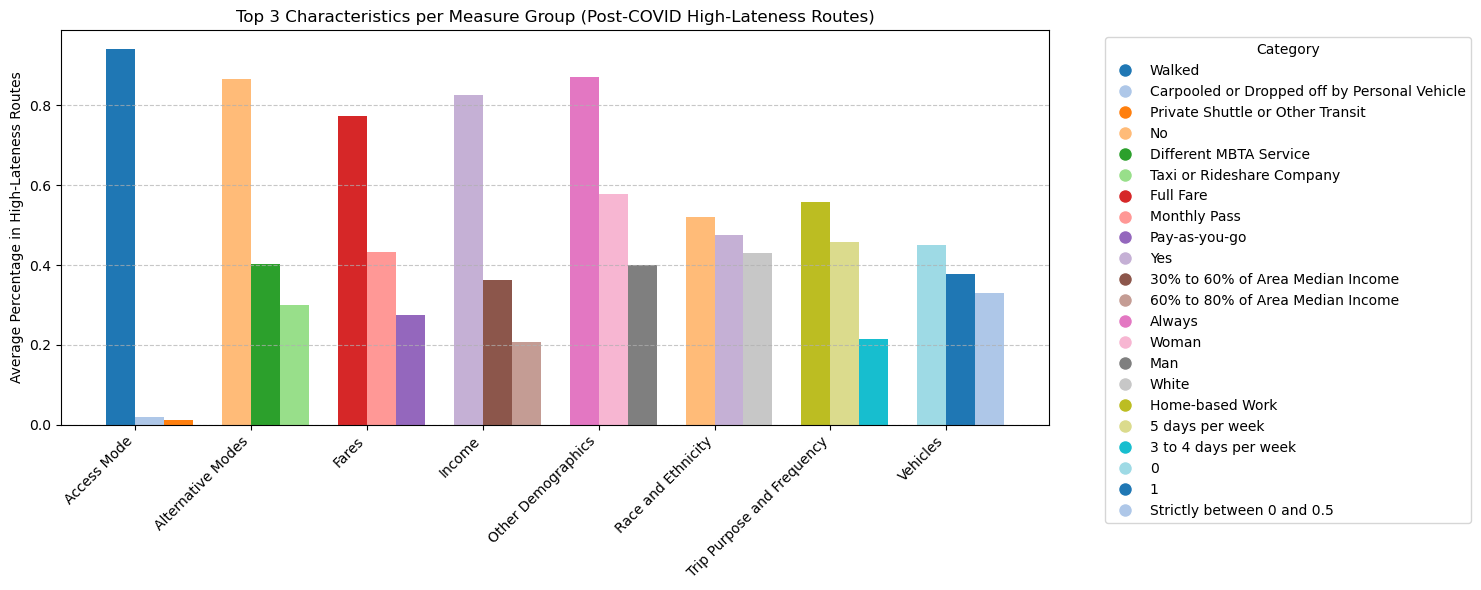

In [19]:
# Visualizing the top characteristics
palette = sns.color_palette("tab20", n_colors=50)
unique_categories = top_categories["category"].unique()
category_to_color = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_categories)}

top_categories["Position"] = top_categories.groupby("measure_group").cumcount()

fig, ax = plt.subplots(figsize=(15, 6))
groups = top_categories["measure_group"].unique()
x = np.arange(len(groups))
width = 0.25

for i in range(top_categories["Position"].max() + 1):
    subset = top_categories[top_categories["Position"] == i]
    bars = ax.bar(
        x + (i - 0.5) * width,
        subset["weighted_percent"],
        width=width,
        color=[category_to_color[cat] for cat in subset["category"]],
        label=None
    )

ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.set_ylabel("Average Percentage in High-Lateness Routes")
ax.set_title("Top 3 Characteristics per Measure Group (Post-COVID High-Lateness Routes)")

handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                      markerfacecolor=color, markersize=10)
           for cat, color in category_to_color.items()]
ax.legend(handles=handles, title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
# display the top categories
top_10 = category_analysis.head(10)
print("Top 10 Categories with Highest Average Percentages in High-Lateness Routes (Post-COVID):\n")
print(top_10.to_string(index=False))

Top 10 Categories with Highest Average Percentages in High-Lateness Routes (Post-COVID):

    measure_group                                     category  weighted_percent
      Access Mode         Bike, Scooter or Other Micromobility          0.011170
      Access Mode Carpooled or Dropped off by Personal Vehicle          0.018487
      Access Mode                                  Drove Alone          0.004573
      Access Mode             Private Shuttle or Other Transit          0.012638
      Access Mode                    Taxi or Rideshare Company          0.011245
      Access Mode                                     The RIDE          0.004762
      Access Mode                                       Walked          0.941235
Alternative Modes        Bike, Scooter, or Other Micromobility          0.075348
Alternative Modes                       Different MBTA Service          0.402469
Alternative Modes                                  Drive Alone          0.182419


In [21]:
df_post["full_category"] = df_post["measure"] + ": " + df_post["category"]
df_post["weighted_percent"] = df_post["weighted_percent"] * 100

# NOW filter using the updated df_post
df_analysis = df_post[df_post["reporting_group"].isin(above_avg_routes["route_id"])]


In [22]:
# pivot to get categories as features
pivot_df = df_analysis.pivot_table(index='reporting_group', 
                                    columns='full_category', 
                                    values='weighted_percent', 
                                    aggfunc='mean').fillna(0)

# merge in lateness
pivot_df = pivot_df.merge(lateness_df[["route_id", "average_lateness"]], 
                          left_index=True, right_on="route_id", how="left")
pivot_df = pivot_df.drop(columns="route_id")

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_df)

#normalizing the features
from sklearn.cluster import KMeans

#kmeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

pivot_df["cluster"] = clusters

,Ability to Understand English: Always,Ability to Understand English: Never,Ability to Understand English: Often,Ability to Understand English: Prefer not to say,Ability to Understand English: Sometimes,"Access to First MBTA Service: Bike, Scooter or Other Micromobility",Access to First MBTA Service: Carpooled or Dropped off by Personal Vehicle,Access to First MBTA Service: Drove Alone,Access to First MBTA Service: Private Shuttle or Other Transit,Access to First MBTA Service: Taxi or Rideshare Company,...,Trip Purpose: Home-based Social Activity,Trip Purpose: Home-based Work,Trip Purpose: Non-home Based,Usable Cars: 0,Usable Cars: 1,Usable Cars: 2,Usable Cars: 3 or more,Used Alternative Mode: No,Used Alternative Mode: Yes,average_lateness
cluster,,,,,,,,,,,,,,,,,,,,,
0,83.192635,1.594123,7.030627,0.321893,7.860722,1.226952,1.929973,0.281991,1.481808,1.283074,...,7.392326,51.730476,8.057827,43.867155,38.812721,14.475734,2.844390,86.958705,13.041295,241.591969
1,90.043881,0.860138,4.173280,0.266361,4.656340,0.983088,1.824122,0.511464,0.853083,0.869884,...,7.380593,61.148730,9.928206,46.229088,35.869431,15.284643,2.616838,86.066498,13.933502,284.763678
2,90.506809,0.667098,4.748715,0.000000,4.077378,0.326108,1.419365,0.000000,0.688776,2.147327,...,10.212118,42.240022,8.881943,37.206538,44.321029,16.239707,2.232727,88.021359,11.978641,350.756948


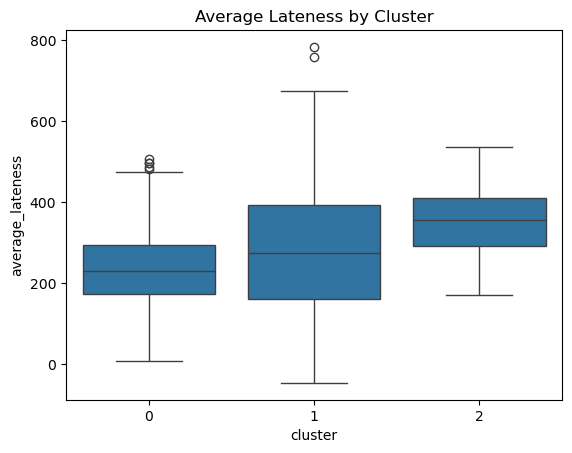

In [24]:
# Show average feature values per cluster
cluster_summary = pivot_df.groupby("cluster").mean()
display(cluster_summary)


sns.boxplot(data=pivot_df, x="cluster", y="average_lateness")
plt.title("Average Lateness by Cluster")
plt.show()

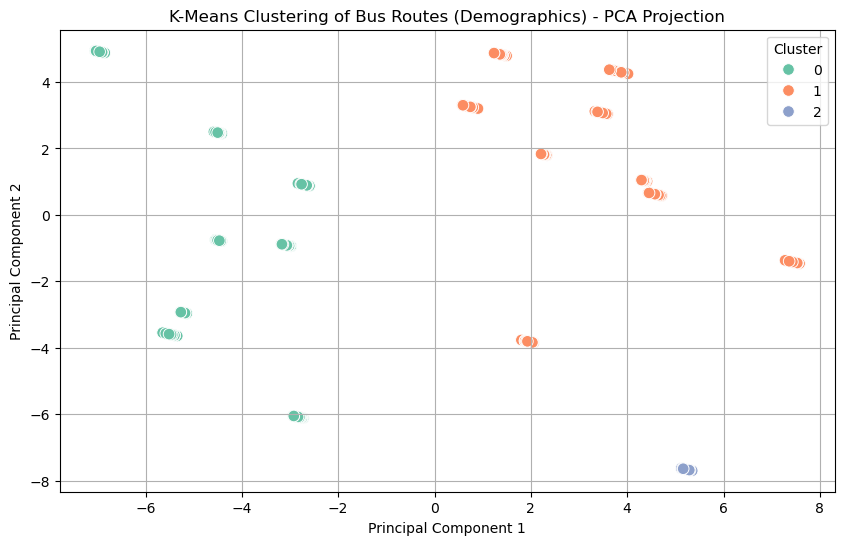

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Create a DataFrame with 2D coordinates and cluster labels
visual_df = pd.DataFrame(reduced_features, columns=["PCA1", "PCA2"])
visual_df["Cluster"] = clusters

# Plot the clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visual_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=70)
plt.title("K-Means Clustering of Bus Routes (Demographics) - PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Now we want to be able to compare the pre covid and post cov lateness and see the change in characteristics over time

In [26]:
#pre covid lateness using the survey dataset 2015-2017 and the departure arrivals from 2018 (closest dataset)
precovid_folder = "ridership_data/2015-2017-tables"
print("Folder contents:", os.listdir(precovid_folder))
file_pattern = os.path.join(precovid_folder, "*export.xlsx")
file_paths   = sorted(glob.glob(file_pattern))
print("Found Excel files:", file_paths)

df_list = [pd.read_excel(file) for file in file_paths]
df_pre = pd.concat(df_list, ignore_index=True)

# Convert route_id to match post-COVID dataset format
above_avg_routes_2018 = above_avg_routes_2018.copy()
above_avg_routes_2018["route_id"] = above_avg_routes_2018["route_id"].astype(str)

df_pre["Route"] = df_pre["Route"].astype(str)

# Merge post-COVID data with routes that had above-average lateness
df_analysis2 = df_pre[df_pre["Route"].isin(above_avg_routes_2018["route_id"])]

print("\nRoutes with Higher Than Average Lateness 2018:")
display(above_avg_routes_2018)

Folder contents: ['fares_data.xlsx', 'income_data.xlsx', 'route_data_export.xlsx', 'trip_purpose_frequency_export.xlsx', 'income_data_export.xlsx', 'other_demographics_data_export.xlsx', 'alt_mode_data.xlsx', 'auto_availability_data_export.xlsx', 'access_mode_data.xlsx', 'access_mode_data_export.xlsx', 'trip_purpose_frequency.xlsx', 'other_demographics_data.xlsx', 'auto_avability_data.xlsx', 'alt_mode_data_export.xlsx', 'race_and_ethnicity_data.xlsx', 'race_and_ethnicity_data_export.xlsx', 'fares_data_export.xlsx']
Found Excel files: ['ridership_data/2015-2017-tables/access_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/alt_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/auto_availability_data_export.xlsx', 'ridership_data/2015-2017-tables/fares_data_export.xlsx', 'ridership_data/2015-2017-tables/income_data_export.xlsx', 'ridership_data/2015-2017-tables/other_demographics_data_export.xlsx', 'ridership_data/2015-2017-tables/race_and_ethnicity_data_export.xlsx', 'ride

,route_id,total_lateness,trip_count,average_lateness
0,01,5233144.0,11810,443.111262
4,08,1137104.0,4410,257.846712
8,101,1296259.0,4063,319.039872
9,104,989244.0,2687,368.159285
10,105,267470.0,834,320.707434
...,...,...,...,...
4523,114,38620.0,132,292.575758
4527,120,433151.0,1290,335.775969
4543,192,19402.0,48,404.208333
4544,193,19791.0,46,430.239130


In [27]:
precovid_folder = "ridership_data/2015-2017-tables"
print("Folder contents:", os.listdir(precovid_folder))
file_pattern = os.path.join(precovid_folder, "*export.xlsx")
file_paths   = sorted(glob.glob(file_pattern))
print("Found Excel files:", file_paths)

top_categories_per_table = {}
late_ids = above_avg_routes_2018["route_id"].astype(str).unique()

for file_path in file_paths:
    df = pd.read_excel(file_path)

    # clean headers & route col
    df.columns = df.columns.str.strip()
    if "Route" not in df.columns:
        continue
    df["Route"] = df["Route"].astype(str)

    # keep only the late routes
    df_filt = df[df["Route"].isin(late_ids)].copy()

    # numeric survey columns already contain % values
    numeric_cols = (
        df_filt
        .select_dtypes("number")
        .columns
        .difference(["Route"])
    )
    if numeric_cols.empty:
        continue

    category_avgs = (
        df_filt[numeric_cols]
        .mean()
        .sort_values(ascending=False)
    )

    tbl_name = os.path.basename(file_path).replace("_data_export.xlsx", "")
    top_categories_per_table[tbl_name] = category_avgs

# quick display
for tbl, ser in top_categories_per_table.items():
    print(f"\nTop categories for {tbl}:")
    display(ser.head(2))


Folder contents: ['fares_data.xlsx', 'income_data.xlsx', 'route_data_export.xlsx', 'trip_purpose_frequency_export.xlsx', 'income_data_export.xlsx', 'other_demographics_data_export.xlsx', 'alt_mode_data.xlsx', 'auto_availability_data_export.xlsx', 'access_mode_data.xlsx', 'access_mode_data_export.xlsx', 'trip_purpose_frequency.xlsx', 'other_demographics_data.xlsx', 'auto_avability_data.xlsx', 'alt_mode_data_export.xlsx', 'race_and_ethnicity_data.xlsx', 'race_and_ethnicity_data_export.xlsx', 'fares_data_export.xlsx']
Found Excel files: ['ridership_data/2015-2017-tables/access_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/alt_mode_data_export.xlsx', 'ridership_data/2015-2017-tables/auto_availability_data_export.xlsx', 'ridership_data/2015-2017-tables/fares_data_export.xlsx', 'ridership_data/2015-2017-tables/income_data_export.xlsx', 'ridership_data/2015-2017-tables/other_demographics_data_export.xlsx', 'ridership_data/2015-2017-tables/race_and_ethnicity_data_export.xlsx', 'ride

Access: Walked or bicycled           94.656566
Previous Mode: Rail rapid transit    68.343434
dtype: float64


Top categories for alt_mode:


Use Alt Mode: Yes                          62.448276
Alt Mode: Take a different MBTA service    49.988506
dtype: float64


Top categories for auto_availability:


License: Yes    74.692308
Vehicles: 1     41.835165
dtype: float64


Top categories for fares:


Pay-Per-Ride Type: Charlie Card (plastic)     81.031579
Monthly Pass Type: LinkPass or Express Bus    75.073684
dtype: float64


Top categories for income:


Low-income: No     65.600000
Low-income: Yes    34.368421
dtype: float64


Top categories for other_demographics:


English Ability: Always    95.107527
Gender: Woman              59.537634
dtype: float64


Top categories for race_and_ethnicity:


Hispanic: No    84.456522
Race: White     61.739130
dtype: float64


Top categories for route:


Trip Purpose: Home-based work    74.377778
Trip Frequency: 5 days a week    57.311111
dtype: float64

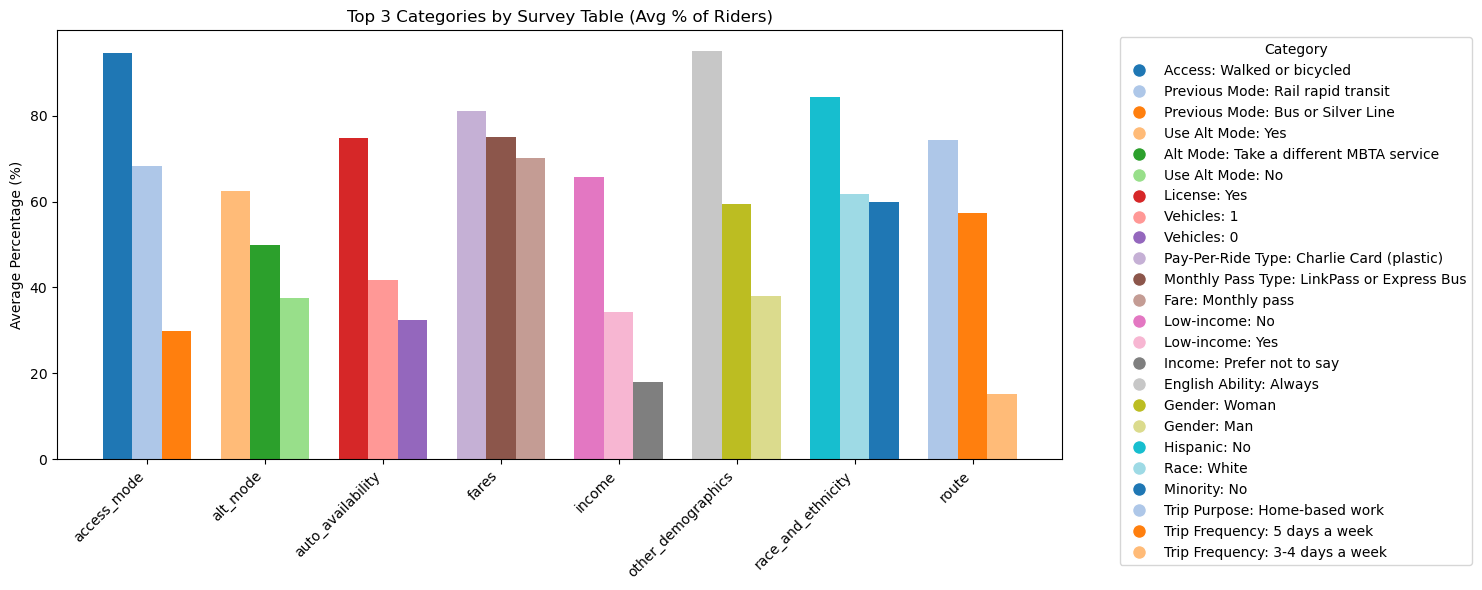

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Use seaborn for better color palette
palette = sns.color_palette("tab20", n_colors=50)

# Prepare flat data: one row per category per table
data_for_plot = []

for table, series in top_categories_per_table.items():
    top3 = series.head(3)
    for category, percent in top3.items():
        data_for_plot.append({
            "Survey Table": table,
            "Category": category,
            "Percentage": percent
        })

plot_df = pd.DataFrame(data_for_plot)

# Assign unique colors per category
unique_categories = plot_df["Category"].unique()
category_to_color = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_categories)}

# Pivot to control bar positions
plot_df["Position"] = plot_df.groupby("Survey Table").cumcount()

# Set plot
fig, ax = plt.subplots(figsize=(15, 6))

x = np.arange(plot_df["Survey Table"].nunique())
width = 0.25

# Draw bars
for i in range(3):
    subset = plot_df[plot_df["Position"] == i]
    bars = ax.bar(
        x + (i - 1) * width,
        subset["Percentage"],
        width=width,
        color=[category_to_color[cat] for cat in subset["Category"]],
        label=None  # skip label here, we'll build legend manually
    )

# X-axis setup
ax.set_xticks(x)
ax.set_xticklabels(plot_df["Survey Table"].unique(), rotation=45, ha="right")
ax.set_ylabel("Average Percentage (%)")
ax.set_title("Top 3 Categories by Survey Table (Avg % of Riders)")

# Build custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
                      markerfacecolor=color, markersize=10)
           for cat, color in category_to_color.items()]
ax.legend(handles=handles, title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Now taking the top categories from the pre covid high lateness routes, and pulling the same categories in the post covid dataset to directly compare the percentages

In [30]:
df_post.columns = df_post.columns.str.strip().str.lower()
df_post['full_category'] = df_post['measure_group'].str.strip() + ": " + df_post['category'].str.strip()

# Filter to high-lateness routes
above_avg_route_ids = above_avg_routes_2018["route_id"].astype(str).unique()
df_post_filtered = df_post[df_post["reporting_group"].astype(str).isin(above_avg_route_ids)]

# Aggregate post-COVID percentages
post_averages = (
    df_post_filtered.groupby("full_category")["weighted_percent"]
    .mean()
    .reset_index()
    .rename(columns={"percentage": "post_covid_percent"})
)

# collect top pre-COVID categories
records = []
for table, series in top_categories_per_table.items():
    for category, pre_pct in series.head(2).items():
        records.append({
            "table": table,
            "full_category": category.strip(),  # clean here too
            "pre_covid_percent": pre_pct
        })

df_top_categories = pd.DataFrame(records)

In [31]:
def normalize(text):
    return str(text).strip().lower().replace("–", "-")


In [32]:
postcovid = os.path.join("ridership_data", "2023.csv")
df_post = pd.read_csv(postcovid)

# Standardize column names
df_post.columns = df_post.columns.str.strip().str.lower()

# Filter only bus routes
df_post = df_post[df_post["service_mode"] == "Bus"]

# Rename and scale percentage
df_post.rename(columns={"weighted_percent": "percentage"}, inplace=True)
df_post["percentage"] *= 100

late_ids = above_avg_routes_2018["route_id"].astype(str).unique()
df_post = df_post[df_post["reporting_group"].astype(str).isin(late_ids)]

# Build combined category label using MEASURE instead of measure_group
df_post["full_category"] = df_post["measure"] + ": " + df_post["category"]

# Use entire dataset for analysis
df_analysis = df_post.copy()

# Group and compute averages by MEASURE and category
category_analysis = (
    df_analysis
    .groupby(["measure", "category"])["percentage"]
    .mean()
    .reset_index()
)

# Use MEASURE instead of measure_group to build full_category
category_analysis["full_category"] = category_analysis["measure"].str.strip() + ": " + category_analysis["category"].str.strip()

# Normalize
import re
def normalize(text):
    if pd.isnull(text):
        return ""
    text = str(text).strip().lower()
    text = re.sub(r"[–—−]", "-", text)
    text = re.sub(r"\s+", " ", text)
    text = text.replace(":", ": ")
    return text.strip()

category_analysis["full_category_clean"] = category_analysis["full_category"].apply(normalize)

#Prepare pre-COVID top categories
records = []
for table, series in top_categories_per_table.items():
    for category, pre_pct in series.head(2).items():
        records.append({
            "table": table,
            "full_category": category.strip(),
            "pre_covid_percent": pre_pct,
            "full_category_clean": normalize(category)
        })

df_top_categories = pd.DataFrame(records)


In [33]:
print("\nTop pre-COVID categories:")
print(df_top_categories["full_category_clean"].sort_values().unique())

print("\nPost-COVID categories (from category_analysis):")
print(category_analysis["full_category_clean"].sort_values().unique())


Top pre-COVID categories:
['access:  walked or bicycled' 'alt mode:  take a different mbta service'
 'english ability:  always' 'gender:  woman' 'hispanic:  no'
 'license:  yes' 'low-income:  no' 'low-income:  yes'
 'monthly pass type:  linkpass or express bus'
 'pay-per-ride type:  charlie card (plastic)'
 'previous mode:  rail rapid transit' 'race:  white'
 'trip frequency:  5 days a week' 'trip purpose:  home-based work'
 'use alt mode:  yes' 'vehicles:  1']

Post-COVID categories (from category_analysis):
['ability to understand english:  always'
 'ability to understand english:  never'
 'ability to understand english:  often'
 'ability to understand english:  prefer not to say'
 'ability to understand english:  sometimes'
 'access to first mbta service:  bike, scooter or other micromobility'
 'access to first mbta service:  carpooled or dropped off by personal vehicle'
 'access to first mbta service:  drove alone'
 'access to first mbta service:  private shuttle or other transit'

In [34]:
# Normalize
df_top_categories["full_category_clean"] = df_top_categories["full_category"].apply(normalize)
category_analysis["full_category_clean"] = category_analysis["full_category"].apply(normalize)

In [35]:
# filter the pre covid categories so only the relevant/important categories are kept
keep_categories = ['access:  walked or bicycled', 'english ability:  always', 'gender:  woman', 'hispanic:  no', 
               'low-income:  no', 'low-income:  yes', 'race:  white', 'trip frequency:  5 days a week', 
               'trip purpose:  home-based work', ]
df_top_categories = df_top_categories[df_top_categories["full_category_clean"].isin(keep_categories)]

# Sanity check
print("\nFiltered pre-COVID categories:")
print(df_top_categories["full_category_clean"].sort_values().unique())



Filtered pre-COVID categories:
['access:  walked or bicycled' 'english ability:  always' 'gender:  woman'
 'hispanic:  no' 'low-income:  no' 'low-income:  yes' 'race:  white'
 'trip frequency:  5 days a week' 'trip purpose:  home-based work']


Since the categories in the post covid dataset vary slightly by name, we have to manually map the names of the top categories from pre covid in the post covid dataset. We chose the top 10 categories, taking out categories that don't tell us much or wouldn't help our analysis

In [36]:
# Manually mapping post-COVID full_category_clean to pre-COVID equivalent
manual_map = {
    "access to first mbta service:  walked": "access: walked or bicycled",
    'gender:  woman': 'gender: woman',
    'race:  white': 'race:  white',
    "access to first mbta service:  bike, scooter or other micromobility": "access: walked or bicycled",
    "ability to understand english:  always": 'english ability: always',
    "hispanic or latino/latina:  no": "hispanic: no",
    "title vi low-income:  no": 'low-income: no',
    "title vi low-income:  yes": 'low-income: yes',
    "frequency:  5 days per week": 'trip frequency: 5 days a week',
    'trip purpose:  home-based work': 'trip purpose: home-based work'
}
category_analysis["full_category_clean_mapped"] = category_analysis["full_category_clean"].replace(manual_map)
# Group by the new mapped category and average the percentage
post_averages = (
    category_analysis
    .groupby("full_category_clean_mapped")["percentage"]
    .mean()
    .reset_index()
    .rename(columns={"full_category_clean_mapped": "full_category_clean", "percentage": "post_covid_percent"})
)
keep_categories = [normalize(x) for x in keep_categories]
df_top_categories["full_category_clean"] = df_top_categories["full_category_clean"].apply(normalize)
category_analysis["full_category_clean"] = category_analysis["full_category_clean"].apply(normalize)


In [38]:
print("Pre-COVID Percentages")
display(
    df_top_categories[["full_category_clean", "pre_covid_percent"]]
    .sort_values(by="full_category_clean")
    .reset_index(drop=True)
)

manual_map_normalized = {
    normalize(k): normalize(v) for k, v in manual_map.items()
}

# Step 2: Apply normalization and mapping to category_analysis
category_analysis["full_category_clean"] = category_analysis["full_category"].apply(normalize)
category_analysis["full_category_clean_mapped"] = category_analysis["full_category_clean"].replace(manual_map_normalized)

# Step 3: Filter only rows that came from manual_map keys
mapped_keys = list(manual_map_normalized.keys())
post_filtered = category_analysis[
    category_analysis["full_category_clean"].isin(mapped_keys)
]

# Step 4: Group and average post-COVID percentages
post_summary = (
    post_filtered
    .groupby("full_category_clean_mapped")["percentage"]
    .mean()
    .reset_index()
    .rename(columns={"full_category_clean_mapped": "full_category_clean", "percentage": "post_covid_percent"})
)

# Step 5: Display the filtered post-COVID data
print("Mapped Post-COVID Categories Only")
display(post_summary.sort_values(by="full_category_clean").reset_index(drop=True))


Pre-COVID Percentages


,full_category_clean,pre_covid_percent
0,access: walked or bicycled,94.656566
1,english ability: always,95.107527
2,gender: woman,59.537634
3,hispanic: no,84.456522
4,low-income: no,65.600000
5,low-income: yes,34.368421
6,race: white,61.739130
7,trip frequency: 5 days a week,57.311111
8,trip purpose: home-based work,74.377778


Mapped Post-COVID Categories Only


,full_category_clean,post_covid_percent
0,access: walked or bicycled,47.586497
1,english ability: always,86.854728
2,gender: woman,58.057830
3,hispanic: no,73.068487
4,low-income: no,17.147486
5,low-income: yes,82.852514
6,race: white,40.825898
7,trip frequency: 5 days a week,45.535083
8,trip purpose: home-based work,54.988806


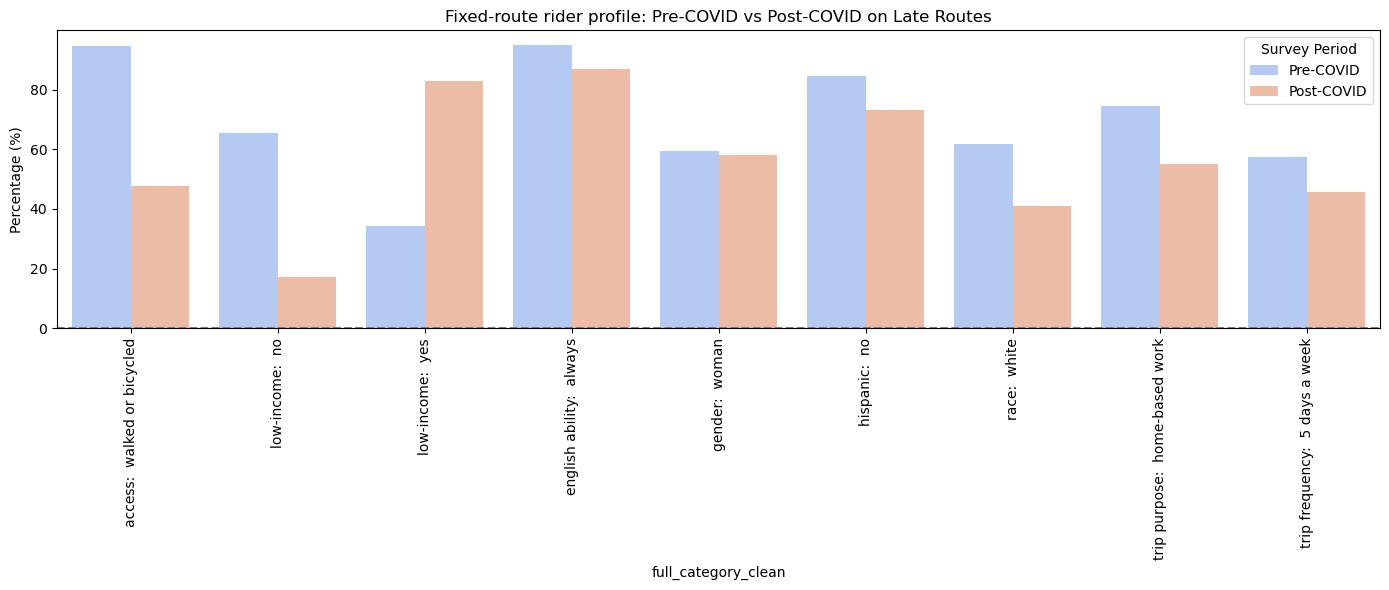

In [39]:

# Step 1: Prepare the data
# Stack pre and post COVID percentages into a single dataframe
pre_covid_plot = df_top_categories[["full_category_clean", "pre_covid_percent"]].copy()
pre_covid_plot["Period"] = "Pre-COVID"
pre_covid_plot = pre_covid_plot.rename(columns={"pre_covid_percent": "Percentage"})

post_covid_plot = post_summary[["full_category_clean", "post_covid_percent"]].copy()
post_covid_plot["Period"] = "Post-COVID"
post_covid_plot = post_covid_plot.rename(columns={"post_covid_percent": "Percentage"})

# Combine the two
plot_df = pd.concat([pre_covid_plot, post_covid_plot], axis=0)

# Step 2: Plot
plt.figure(figsize=(14, 6))
sns.barplot(
    data=plot_df,
    x="full_category_clean",
    y="Percentage",
    hue="Period",       # Separate colors for Pre/Post COVID
    palette="coolwarm"
)
plt.xticks(rotation=90)
plt.ylabel("Percentage (%)")
plt.title("Fixed-route rider profile: Pre-COVID vs Post-COVID on Late Routes")
plt.axhline(0, color="gray", ls="--")
plt.legend(title="Survey Period")
plt.tight_layout()
plt.show()


# Ridership 
this section will answer the following questions: 
### what is the average ridership per bus route? 
### How has this changed from pre-pandemic to post-pandemic time? 

In [ ]:
import pandas as pd
file_path = "MBTA_Bus_Ridership_by_Trip%2C_Season%2C_Route_Line%2C_and_Stop (1).csv"
df = pd.read_csv(file_path)
print(df.head())

In [ ]:
# Group by 'season' first to process each chunk
season_chunks = df.groupby('season')

# List to hold all aggregated DataFrames for each season
aggregated_df_list = []

for season, season_data in season_chunks:
    # Sort by route_id, direction_id, stop_sequence, and stop_id to ensure correct order
    season_data = season_data.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])
    
    # Perform aggregation (sum of boardings and alightings)
    aggregated_season_df = season_data.groupby(['season', 'route_id', 'direction_id', 'stop_sequence', 'stop_id', 'stop_name']).agg(
        avg_boardings=('boardings', 'sum'),
        avg_alightings=('alightings', 'sum')
    ).reset_index()
    
    # Add 'traffic' column by summing boardings and alightings
    aggregated_season_df['traffic'] = aggregated_season_df['avg_boardings'] + aggregated_season_df['avg_alightings']
    
    # Sort to maintain order
    aggregated_season_df = aggregated_season_df.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])

    # Add to the list of DataFrames
    aggregated_df_list.append(aggregated_season_df)

# Combine all chunks into one DataFrame
final_aggregated_df = pd.concat(aggregated_df_list, ignore_index=True)

# Print the final aggregated DataFrame
print(final_aggregated_df)

In [ ]:
stops = pd.read_csv("stops.csv")
print("Preview of the CSV data:")
print("Hello" ,final_aggregated_df.size)
print(stops.head())
print("\nColumns in the CSV:", stops.columns)

stops['route'] = stops['stop_desc'].astype(str)  
stops = stops.dropna(subset=['route'])

merged_coordinates = stops.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first'
})


final_aggregated_df = final_aggregated_df.drop(columns=['stop_lat', 'stop_lon'], errors='ignore')
final_aggregated_df = pd.merge(final_aggregated_df, merged_coordinates, on='stop_id', how='left')
print("\nFinal Merged DataFrame with Coordinates:")
print(final_aggregated_df)

I have merged the tables together so that each stop has a corresponding lat and long. 

In [ ]:
columns_to_drop = [
    'platform_code', 'stop_desc', 'parent_station', 'wheelchair_boarding',
    'platform_name', 'zone_id', 'stop_address', 'stop_url',
    'level_id', 'location_type', 'municipality','platform_code_x', 'platform_name_x'
]

final_aggregated_df = final_aggregated_df.drop(columns=columns_to_drop, errors='ignore')  

# Display DataFrame
print("DataFrame after removing unwanted columns:")
print(final_aggregated_df.columns)

In [ ]:
# Drop duplicate columns keeping only the final versions
final_aggregated_df = final_aggregated_df.drop(columns=[
    'stop_name_x', 'stop_name_y', 'route_x', 'route_y', 'stop_code_x', 'stop_code_y',
    'stop_desc_x', 'stop_desc_y', 'platform_code_y', 'platform_name_y',
    'stop_lat_x', 'stop_lat_y', 'stop_lon_x', 'stop_lon_y', 'zone_id_x', 'zone_id_y',
    'stop_address_x', 'stop_address_y', 'stop_url_x', 'stop_url_y', 'level_id_x', 'level_id_y',
    'location_type_x', 'location_type_y', 'parent_station_x', 'parent_station_y',
    'wheelchair_boarding_x', 'wheelchair_boarding_y', 'municipality_x', 'municipality_y',
    'on_street_x', 'on_street_y', 'at_street_x', 'at_street_y', 'vehicle_type_x', 'vehicle_type_y'
], errors='ignore')


print("Final Cleaned DataFrame:")
final_aggregated_df.to_csv("cleaned_final_set(post 2019).csv", index = False)
print(final_aggregated_df)

For the ARCGIS, we wanted to graph all the points changing over the years. 

In [ ]:
ArcGIS = final_aggregated_df.copy()
ArcGIS = ArcGIS[['season', 'stop_lat', 'stop_lon', 'traffic']]
ArcGIS = ArcGIS.dropna() 
ArcGIS.to_csv("ArcGIS(Traffic).csv", index = False)
print(ArcGIS.columns)

#### First run will be Pre-COVID

In [ ]:
import matplotlib.pyplot as plt


final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'].between(2016, 2019)]


final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',  
    'stop_lon': 'first',
    'season': 'first',  
    'traffic': 'sum' 
})

# Plot the stops on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(final_aggregated_df['stop_lon'], final_aggregated_df['stop_lat'], alpha=0.6, c='blue', edgecolors='black')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (2016-2019)")
plt.grid(True)
plt.show()

In [ ]:
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'].between(2016, 2019)]
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',  
    'stop_lon': 'first',
    'season': 'first',  
    'traffic': 'sum' 
})

# Normalize the traffic (to map it to a color scale)
traffic = final_aggregated_df['traffic']
norm = plt.Normalize(traffic.min(), traffic.max())  # Normalize for color scaling
cmap = plt.get_cmap("plasma")  # Choose a more contrasting colormap
plt.figure(figsize=(12, 8))
scatter = plt.scatter(final_aggregated_df['stop_lon'], final_aggregated_df['stop_lat'], 
                      c=traffic, cmap=cmap, alpha=0.8, edgecolors='black', norm=norm, s=100)


plt.colorbar(scatter, label='Traffic')


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (2016-2019) with Traffic Volume")
plt.grid(True)

plt.show()

In [ ]:
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'].between(2016, 2019)]

# Group by stop_id and aggregate lat/lon by taking the first value
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first',
    'season': 'first',
    'traffic': 'sum' 
})

# Compute IQR for traffic to detect outliers
Q1 = final_aggregated_df['traffic'].quantile(0.25)
Q3 = final_aggregated_df['traffic'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds because it goes negative since the range pushes it before
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

low_outliers = final_aggregated_df[final_aggregated_df['traffic'] < lower_bound]  # Too low → Bright Pink
high_outliers = final_aggregated_df[final_aggregated_df['traffic'] > upper_bound]  # Too high → Green
normal_data = final_aggregated_df[(final_aggregated_df['traffic'] >= lower_bound) & (final_aggregated_df['traffic'] <= upper_bound)]
print(low_outliers)
print(upper_bound)
# Plot the stops
plt.figure(figsize=(12, 8))

# Plot normal stops in gray
plt.scatter(normal_data['stop_lon'], normal_data['stop_lat'], 
            color='gray', edgecolors='black', s=100, label='Normal Stops')

# Plot low outliers (bright pink)
plt.scatter(low_outliers['stop_lon'], low_outliers['stop_lat'], 
            color='deeppink', edgecolors='black', s=120, label='Low Outliers')

# Plot high outliers (green)
plt.scatter(high_outliers['stop_lon'], high_outliers['stop_lat'], 
            color='limegreen', edgecolors='black', s=120, label='High Outliers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (2016-2019)\nLow Outliers = Pink, High Outliers = Green")
plt.legend()
plt.grid(True)

plt.show()

I will be using the final we generated earlier called "Cleaned_final_set.csv"

In [ ]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

file_path = "cleaned_final_set.csv"
df = pd.read_csv(file_path)

df.head()

In [ ]:
df['year'] = df['season'].str.extract(r'(\d{4})').astype(float)
df = df[df['year'].between(2016, 2019)]
grouped_df = df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',   
    'stop_lon': 'first',   
    'traffic': 'sum'       
})

grouped_df['grouped_season'] = "2016-2019"

# Display the grouped dataset
print(grouped_df.head())

In [ ]:
grouped_df = df.dropna(subset=["stop_lat", "stop_lon"])

X = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
X["traffic"] = (X["traffic"] - X["traffic"].mean()) / X["traffic"].std()

cost = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
grouped_df["cluster"] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means Clustering of Stops (K={4})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

In [ ]:
cluster_ridership_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_ridership_summary

In [ ]:
cluster_0_df = grouped_df[grouped_df["cluster"] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_0_df["stop_lon"], cluster_0_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 1")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

X_original = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
print(X_original)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
print(X_scaled)

In [ ]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 7 
kmeans = KMeans(n_clusters=optimal_k)
grouped_df["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Standardized K-Means Clustering of Stops (K={optimal_k})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


In [ ]:
cluster_lateness_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_lateness_summary

#### DBScan 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csv_file = "cleaned_final_set.csv"
df = pd.read_csv(csv_file)
df = df.dropna(subset=["stop_lat", "stop_lon"])
X = df[["stop_lat", "stop_lon", "traffic"]].copy()
X

In [ ]:
df['year'] = df['season'].str.extract(r'(\d{4})').astype(float)
df = df[df['year'].between(2016, 2019)]

# Group data by stop_id and aggregate relevant columns
X_df = df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',    # Keep the first latitude value per stop
    'stop_lon': 'first',    # Keep the first longitude value per stop
    'traffic': 'sum'        # Sum up the traffic across all selected years
})

X_df['grouped_season'] = "2016-2019"

X_df.drop(columns='grouped_season', inplace=True)

print(X_df.tail())

In [ ]:
X_df = df[["stop_lon", "stop_lat"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=7)
df["cluster"] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["stop_lon"], df["stop_lat"], c=df["cluster"], cmap="viridis", alpha=0.01
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Stops")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()
cluster_ridership_summary = df.groupby("cluster").agg(
    traffic=("traffic", "mean"),   # Average traffic per cluster
    num_stops=("stop_id", "count") # Number of stops in each cluster
).reset_index()

cluster_ridership_summary = cluster_ridership_summary.sort_values(by="traffic")
cluster_ridership_summary



# Post COVID ridership 

In [ ]:
import pandas as pd
file_path = "MBTA_Bus_Ridership_by_Trip%2C_Season%2C_Route_Line%2C_and_Stop (1).csv"
df = pd.read_csv(file_path)
print(df.head())

In [ ]:
# Group by 'season' first to process each chunk
season_chunks = df.groupby('season')

# List to hold all aggregated DataFrames for each season
aggregated_df_list = []

for season, season_data in season_chunks:
    # Sort by route_id, direction_id, stop_sequence, and stop_id to ensure correct order
    season_data = season_data.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])
    
    # Perform aggregation (sum of boardings and alightings)
    aggregated_season_df = season_data.groupby(['season', 'route_id', 'direction_id', 'stop_sequence', 'stop_id', 'stop_name']).agg(
        avg_boardings=('boardings', 'sum'),
        avg_alightings=('alightings', 'sum')
    ).reset_index()
    
    # Add 'traffic' column by summing boardings and alightings
    aggregated_season_df['traffic'] = aggregated_season_df['avg_boardings'] + aggregated_season_df['avg_alightings']
    
    # Sort to maintain order
    aggregated_season_df = aggregated_season_df.sort_values(by=['route_id', 'direction_id', 'stop_sequence', 'stop_id'])

    # Add to the list of DataFrames
    aggregated_df_list.append(aggregated_season_df)

# Combine all chunks into one DataFrame
final_aggregated_df = pd.concat(aggregated_df_list, ignore_index=True)

# Print the final aggregated DataFrame
print(final_aggregated_df)


In [ ]:
stops = pd.read_csv("stops.csv")
print("Preview of the CSV data:")
print("Hello" ,final_aggregated_df.size)
print(stops.head())
print("\nColumns in the CSV:", stops.columns)

stops['route'] = stops['stop_desc'].astype(str)  
stops = stops.dropna(subset=['route'])

merged_coordinates = stops.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first'
})


final_aggregated_df = final_aggregated_df.drop(columns=['stop_lat', 'stop_lon'], errors='ignore')
final_aggregated_df = pd.merge(final_aggregated_df, merged_coordinates, on='stop_id', how='left')
print("\nFinal Merged DataFrame with Coordinates:")
print(final_aggregated_df)


In [ ]:
columns_to_drop = [
    'platform_code', 'stop_desc', 'parent_station', 'wheelchair_boarding',
    'platform_name', 'zone_id', 'stop_address', 'stop_url',
    'level_id', 'location_type', 'municipality','platform_code_x', 'platform_name_x'
]

final_aggregated_df = final_aggregated_df.drop(columns=columns_to_drop, errors='ignore')  

# Display DataFrame
print("DataFrame after removing unwanted columns:")
print(final_aggregated_df.columns)

In [ ]:
# Drop duplicate columns keeping only the final versions
final_aggregated_df = final_aggregated_df.drop(columns=[
    'stop_name_x', 'stop_name_y', 'route_x', 'route_y', 'stop_code_x', 'stop_code_y',
    'stop_desc_x', 'stop_desc_y', 'platform_code_y', 'platform_name_y',
    'stop_lat_x', 'stop_lat_y', 'stop_lon_x', 'stop_lon_y', 'zone_id_x', 'zone_id_y',
    'stop_address_x', 'stop_address_y', 'stop_url_x', 'stop_url_y', 'level_id_x', 'level_id_y',
    'location_type_x', 'location_type_y', 'parent_station_x', 'parent_station_y',
    'wheelchair_boarding_x', 'wheelchair_boarding_y', 'municipality_x', 'municipality_y',
    'on_street_x', 'on_street_y', 'at_street_x', 'at_street_y', 'vehicle_type_x', 'vehicle_type_y'
], errors='ignore')


print("Final Cleaned DataFrame:")
final_aggregated_df.to_csv("cleaned_final_set(post 2019).csv", index = False)
print(final_aggregated_df)

In [ ]:
ArcGIS = final_aggregated_df.copy()
ArcGIS = ArcGIS[['season', 'stop_lat', 'stop_lon', 'traffic']]
ArcGIS = ArcGIS.dropna() 
ArcGIS.to_csv("ArcGIS(traffic Post).csv", index = False)
print(ArcGIS.columns)

In [ ]:
import matplotlib.pyplot as plt


final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]
print("Hello", final_aggregated_df.size)

final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',  
    'stop_lon': 'first',
    'season': 'first',  
    'traffic': 'sum' 
})

plt.figure(figsize=(10, 6))
plt.scatter(final_aggregated_df['stop_lon'], final_aggregated_df['stop_lat'], alpha=0.6, c='blue', edgecolors='black')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (Post 2019)")
plt.grid(True)
plt.show()

In [ ]:
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]
print("Hello", final_aggregated_df.size)
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first',
    'season': 'first',
    'traffic': 'sum'
})

# Normalize the traffic (to map it to a color scale)
traffic = final_aggregated_df['traffic']
norm = plt.Normalize(traffic.min(), traffic.max())
cmap = plt.get_cmap("plasma")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    final_aggregated_df['stop_lon'],
    final_aggregated_df['stop_lat'],
    c=traffic,
    cmap=cmap,
    alpha=0.8,
    edgecolors='black',
    norm=norm,
    s=100
)

plt.colorbar(scatter, label='Traffic')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (Post 2019) with Traffic Volume")
plt.grid(True)
plt.show()


In [ ]:
# Extract year and filter for years after 2019
final_aggregated_df['year'] = final_aggregated_df['season'].str.extract(r'(\d{4})').astype(float)
final_aggregated_df = final_aggregated_df[final_aggregated_df['year'] > 2019]

# Group by stop_id and aggregate lat/lon by taking the first value
final_aggregated_df = final_aggregated_df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',
    'stop_lon': 'first',
    'season': 'first',
    'traffic': 'sum' 
})

# Compute IQR for traffic to detect outliers
Q1 = final_aggregated_df['traffic'].quantile(0.25)
Q3 = final_aggregated_df['traffic'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds (lower bound set to >= 0)
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Classify data points
low_outliers = final_aggregated_df[final_aggregated_df['traffic'] < lower_bound]      # Bright Pink
high_outliers = final_aggregated_df[final_aggregated_df['traffic'] > upper_bound]     # Green
normal_data = final_aggregated_df[(final_aggregated_df['traffic'] >= lower_bound) & 
                                  (final_aggregated_df['traffic'] <= upper_bound)]

print(low_outliers)
print("Upper bound for outlier detection:", upper_bound)

# Plot the stops
plt.figure(figsize=(12, 8))

# Normal stops
plt.scatter(normal_data['stop_lon'], normal_data['stop_lat'], 
            color='gray', edgecolors='black', s=100, label='Normal Stops')

# Low traffic outliers
plt.scatter(low_outliers['stop_lon'], low_outliers['stop_lat'], 
            color='deeppink', edgecolors='black', s=120, label='Low Outliers')

# High traffic outliers
plt.scatter(high_outliers['stop_lon'], high_outliers['stop_lat'], 
            color='limegreen', edgecolors='black', s=120, label='High Outliers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transit Stops (2020 and Beyond)\nLow Outliers = Pink, High Outliers = Green")
plt.legend()
plt.grid(True)
plt.show()


#### K MEANS 

In [ ]:
import pandas as pd
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

file_path = "cleaned_final_set(post 2019).csv"
df = pd.read_csv(file_path)

df.head()

In [ ]:
df['year'] = df['season'].str.extract(r'(\d{4})').astype(float)
df = df[df['year'] > 2019]

grouped_df = df.groupby('stop_id', as_index=False).agg({
    'stop_lat': 'first',   
    'stop_lon': 'first',   
    'traffic': 'sum'       
})

grouped_df['grouped_season'] = "2020 and beyond"

# Display the grouped dataset
print(grouped_df.head())

In [ ]:
grouped_df = df.dropna(subset=["stop_lat", "stop_lon"])

X = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
X["traffic"] = (X["traffic"] - X["traffic"].mean()) / X["traffic"].std()

cost = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
grouped_df["cluster"] = kmeans.fit_predict(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means Clustering of Stops (K={4})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

In [ ]:
cluster_ridership_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_ridership_summary

In [ ]:
cluster_0_df = grouped_df[grouped_df["cluster"] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_0_df["stop_lon"], cluster_0_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 1]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 0")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 2]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
cluster_1_df = grouped_df[grouped_df["cluster"] == 3]

plt.figure(figsize=(10, 6))
plt.scatter(
    cluster_1_df["stop_lon"], cluster_1_df["stop_lat"], c="blue", alpha=0.7, label="Cluster 0"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Clustering - Only Cluster 3")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

X_original = grouped_df[["stop_lat", "stop_lon", "traffic"]].copy()
print(X_original)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
print(X_scaled)

In [ ]:
inertia = []
K_range = range(2, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 7 
kmeans = KMeans(n_clusters=optimal_k)
grouped_df["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    grouped_df["stop_lon"], grouped_df["stop_lat"], c=grouped_df["cluster"], cmap="viridis", alpha=0.7
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Standardized K-Means Clustering of Stops (K={optimal_k})")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()

In [ ]:
cluster_lateness_summary = grouped_df.groupby("cluster")["traffic"].mean().reset_index()

cluster_lateness_summary

In [ ]:
X_df = df[["stop_lon", "stop_lat"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=7)
df["cluster"] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df["stop_lon"], df["stop_lat"], c=df["cluster"], cmap="viridis", alpha=0.01
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Stops")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()
cluster_ridership_summary = df.groupby("cluster").agg(
    traffic=("traffic", "mean"),   # Average traffic per cluster
    num_stops=("stop_id", "count") # Number of stops in each cluster
).reset_index()

cluster_ridership_summary = cluster_ridership_summary.sort_values(by="traffic")
cluster_ridership_summary

### Answer: decline in ridership after COVID

In [ ]:
import pandas as pd
file_path = "MBTA_Bus_Ridership_by_Trip%2C_Season%2C_Route_Line%2C_and_Stop (1).csv"
df = pd.read_csv(file_path)
print(df.head())


In [ ]:
chunk_size = 100000
result_df =df
# Process the data in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Sum the boardings per route and season in each chunk
    chunk_agg = chunk.groupby(['route_id', 'season'])['boardings'].sum().reset_index()
    
    # Concatenate the results to the final DataFrame
    result_df = pd.concat([result_df, chunk_agg])

# After concatenating all chunks, re-group and calculate the final sum
final_agg = result_df.groupby(['route_id', 'season'])['boardings'].sum().reset_index()

# Show the final aggregated boardings
print(final_agg)

In [ ]:
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Add a new column 'year' based on the 'season' column (assuming 'season' contains the year information)
    chunk['year'] = chunk['season'].str.extract(r'(\d{4})').astype(int)  # Extract year from 'season'
    
    # Group the data into two periods: 2016-2019 and Post 2019
    chunk['time_period'] = chunk['year'].apply(lambda x: '2016-2019' if 2016 <= x <= 2019 else 'Post 2019')
    
    # Aggregate the data by 'route_id' and 'time_period', summing the 'boardings'
    chunk_avg = chunk.groupby(['route_id', 'time_period'])['boardings'].sum().reset_index()
      
    # Concatenate the results to the final DataFrame
    result_df = pd.concat([result_df, chunk_avg])

# After concatenating all chunks, re-group and calculate the final aggregate
final_avg = result_df.groupby(['route_id', 'time_period'])['boardings'].sum().reset_index()

# Show the final results
print(final_avg)

In [ ]:
# Group by 'route_id' and 'time_period' to check if both pre and post 2019 exist for each route
route_seasons = final_avg.groupby('route_id')['time_period'].apply(set)

# Filter out routes that don't have both '2016-2019' and 'Post 2019'
valid_routes = route_seasons[route_seasons.apply(lambda x: {'2016-2019', 'Post 2019'}.issubset(x))].index

# Filter the original DataFrame to keep only valid routes
filtered_df = final_avg[final_avg['route_id'].isin(valid_routes)]

# Display the filtered DataFrame
print(filtered_df)

In [ ]:
# Pivot the data to have '2016-2019' and 'Post 2019' as columns for each route
pivoted_df = filtered_df.pivot(index='route_id', columns='time_period', values='boardings')
# absolute change between
pivoted_df['absolute_change'] = (pivoted_df['Post 2019'] - pivoted_df['2016-2019'])
# Reset the index
pivoted_df.reset_index(inplace=True)
print(pivoted_df[['route_id', '2016-2019', 'Post 2019', 'absolute_change']])

In [ ]:
average_percent_change = pivoted_df['absolute_change'].median()
print(f"The average percent change across all routes is: {average_percent_change:.2f}")

#### Answer: Broadly speaking, the absolute change in ridership is that there is a decrease of 558.55 riders pre and post covid. 